In [ ]:
# ========================================
# NFAM FRAMEWORK - COMPLETE IMPLEMENTATION
# Mental Health Analytics System
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                            silhouette_score, davies_bouldin_score, r2_score,
                            mean_absolute_error, mean_squared_error)
import xgboost as xgb
import shap
import networkx as nx
from collections import Counter
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("="*80)
print(" " * 20 + "NFAM FRAMEWORK - COMPLETE IMPLEMENTATION")
print("="*80)
print()


                    NFAM FRAMEWORK - COMPLETE IMPLEMENTATION



In [ ]:
# ========================================
# STEP 1: Setup & Data Loading
# ========================================
print("\n" + "="*80)
print("STEP 1: SETUP & DATA LOADING")
print("="*80)

# Load the dataset
df = pd.read_excel("Mental_Health_Survey_VIT_Aligned_350.xlsx")

print(f"\n✓ Dataset loaded successfully!")
print(f"  Total records: {len(df)}")
print(f"  Total columns: {len(df.columns)}")
print(f"\nDataset Preview:")
print(df.head(3))



STEP 1: SETUP & DATA LOADING

✓ Dataset loaded successfully!
  Total records: 350
  Total columns: 61

Dataset Preview:
         Name  Gender Enter age *  Program *  \
0  Harshini H  Female       18-20  Int Mtech   
1  k.veerraju    Male       18-20  Int Mtech   
2     Koushik    Male       18-20  Int Mtech   

  Year and Current semester you are in * Department *  Credits taken *  \
0                                   sem7        SCOPE               29   
1                                   sem9        SCOPE               29   
2                                   sem9        SCOPE               26   

  Current CGPA (Overall GPA) * Class Hours and lab per Week *  \
0                   6.0 to 7.0                   less than 20   
1                   6.0 to 7.0                   less than 50   
2                   5.0 to 6.0                   less than 20   

  Approximate class timing blocks allotted  *  ...  \
0                                8 am - 10 am  ...   
1                   

In [ ]:
# ========================================
# STEP 2: Feature Extraction & Mapping
# ========================================
print("\n" + "="*80)
print("STEP 2: FEATURE EXTRACTION & MAPPING")
print("="*80)

# Create working copy
df_work = df.copy()


# ---------------------------------------------------------------------
# 🧩 1. Normalize column names to handle hidden characters & spaces
# ---------------------------------------------------------------------
df_work.columns = df_work.columns.str.replace('\u200b', '', regex=True)   # remove zero-width chars
df_work.columns = df_work.columns.str.replace('\xa0', ' ', regex=True)    # replace non-breaking spaces
df_work.columns = df_work.columns.str.strip()

print("\n🔹 Original Columns:")
print(df.columns.tolist()) # Print original columns for comparison


# ---------------------------------------------------------------------
# 🧠 2. Safe column mapping
# ---------------------------------------------------------------------
column_mapping = {
    'Enter age *': 'Age',
    'Gender': 'Gender',
    'Program *': 'Program',
    'Year and Current semester you are in *': 'Semester',
    'Department *': 'Department',
    'Credits taken *': 'Credits',
    'Current CGPA (Overall GPA) *': 'CGPA',
    'Class Hours and lab per Week *': 'ClassHours',
    'Average attention per class *': 'AttentionPerClass',
    'Distraction rate during class *': 'DistractionRate',
    'Average daily study time on weekdays *': 'StudyTimeWeekday',
    'Average daily study time on weekends *': 'StudyTimeWeekend',
    'Average daily study time on weekends   *': 'StudyTimeWeekend',
    'Average sleep duration on weekdays *': 'SleepWeekday',
    'Average sleep duration on weekdays   *': 'SleepWeekday',
    'Average sleep duration on weekends *': 'SleepWeekend',
    'Average sleep duration on weekends   *': 'SleepWeekend',
    'Sleep quality *': 'SleepQuality',
    'Daytime sleepiness affects my classes. *': 'DaytimeSleepiness',
    'Average daily screen time *': 'ScreenTime',
    'Average social media time per day *': 'SocialMediaTime',
    'One-way commute time to campus *': 'CommuteTime', # Ensure this is correct
    'Regular exercise habit *': 'ExerciseHabit',
    'Feeling nervous, anxious, stressed, demotivated *': 'MentalHealthStatus',
    'Not being able to stop or control worrying *': 'WorryLevel',
    'Feeling down, depressed, or hopeless *': 'DepressionLevel',
    'How often do you feel like crying? *': 'EmotionalDistress',
}

# ---------------------------------------------------------------------
# 🔄 3. Apply mapping safely (handles partial and fuzzy matches)
# ---------------------------------------------------------------------
# Create a dictionary mapping cleaned original names to current df_work names
cleaned_to_current = {col.strip('* ').lower(): col for col in df_work.columns}

for old_col, new_col in column_mapping.items():
    cleaned_old_col = old_col.strip('* ').lower()
    # Look for an exact match first
    if old_col in df_work.columns:
        df_work.rename(columns={old_col: new_col}, inplace=True)
    # Then try fuzzy matching with cleaned names
    elif cleaned_old_col in cleaned_to_current:
         df_work.rename(columns={cleaned_to_current[cleaned_old_col]: new_col}, inplace=True)
    else:
        print(f"⚠️ Warning: Column '{old_col}' not found in the DataFrame for mapping to '{new_col}'.")


print("\n✅ After Mapping Columns:")
print(df_work.columns.tolist()) # Print columns after mapping


# ---------------------------------------------------------------------
# 🧹 4. Basic cleanup (handle missing values and parse categories)
# ---------------------------------------------------------------------

# Parse hours function
def parse_hours(value):
    if pd.isna(value):
        return np.nan
    value_str = str(value).lower().strip()
    hour_mappings = {
        '0-1': 0.5, '1-2': 1.5, '2-3': 2.5, '3-4': 3.5,
        '4-5': 4.5, '5-6': 5.5, '6-7': 6.5, '7-8': 7.5,
        '8-9': 8.5, '9-10': 9.5, '10+': 10.5,
        'less than 1': 0.5, 'more than 10': 11,
        'none': 0, 'minimal': 0.5,
        'less than 20': 10, 'less than 50': 25, '50+': 55,
        '30-60m': 0.75, '1-2 hr': 1.5, '2-3 hrs': 2.5
    }
    for key, val in hour_mappings.items():
        if key in value_str:
            return val
    try:
        # Attempt to convert to float if not in mappings
        return float(value_str)
    except ValueError:
        # Return NaN for values that cannot be parsed
        return np.nan


# Parse Likert scale
def parse_likert_scale(value):
    if pd.isna(value):
        return np.nan
    value_str = str(value).lower().strip()
    likert_mappings = {
        'never': 1, 'rarely': 2, 'sometimes': 3,
        'often': 4, 'always': 5, 'very often': 5,
        'not at all': 1, 'several days': 2,
        'more than half': 4, 'nearly every day': 5,
        'poor': 1, 'fair': 2, 'good': 3,
        'very good': 4, 'excellent': 5,
        'strongly disagree': 1, 'disagree': 2, 'neutral': 3, 'agree': 4, 'strongly agree': 5
    }
    for key, val in likert_mappings.items():
        if key in value_str:
            return val
    try:
        # Attempt to convert to float if not in mappings (in case of numeric entries)
        return float(value_str)
    except ValueError:
        # Default to Neutral (3) if parsing fails
        return 3


# Apply conversions
time_columns = ['StudyTimeWeekday', 'StudyTimeWeekend', 'SleepWeekday',
                'SleepWeekend', 'ScreenTime', 'SocialMediaTime', 'CommuteTime', 'ClassHours']
for col in time_columns:
    if col in df_work.columns:
        df_work[col] = df_work[col].apply(parse_hours)
        # Convert to numeric after parsing to ensure correct data type
        df_work[col] = pd.to_numeric(df_work[col], errors='coerce')


likert_columns = ['DistractionRate', 'DaytimeSleepiness', 'SleepQuality',
                  'MentalHealthStatus', 'WorryLevel', 'DepressionLevel',
                  'EmotionalDistress', 'AttentionPerClass', 'ExerciseHabit']
for col in likert_columns:
    if col in df_work.columns:
        df_work[col] = df_work[col].apply(parse_likert_scale)
        # Convert to numeric after parsing to ensure correct data type
        df_work[col] = pd.to_numeric(df_work[col], errors='coerce')

# Handle remaining missing values by imputing with median of numeric columns
numeric_cols = df_work.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_work[col].isna().sum() > 0:
        df_work[col].fillna(df_work[col].median(), inplace=True)


# ---------------------------------------------------------------------
# 🧮 5. Create derived features safely
# ---------------------------------------------------------------------
# Combined study time (weighted 5 weekdays + 2 weekends)
if 'StudyTimeWeekday' in df_work.columns and 'StudyTimeWeekend' in df_work.columns:
    df_work['StudyHours'] = (df_work['StudyTimeWeekday'] * 5 + df_work['StudyTimeWeekend'] * 2) / 7
else:
    print("⚠️ Could not compute StudyHours (missing columns).")

# Combined sleep duration (weighted 5 weekdays + 2 weekends)
if 'SleepWeekday' in df_work.columns and 'SleepWeekend' in df_work.columns:
    df_work['SleepHours'] = (df_work['SleepWeekday'] * 5 + df_work['SleepWeekend'] * 2) / 7
else:
    print("⚠️ Could not compute SleepHours (missing columns).")

# Composite mental fatigue indicator (scaled)
if {'DistractionRate', 'DaytimeSleepiness', 'WorryLevel', 'DepressionLevel'}.issubset(df_work.columns):
    df_work['MentalFatigue'] = (
        df_work['DistractionRate'] + df_work['DaytimeSleepiness'] + df_work['WorryLevel'] + df_work['DepressionLevel']
    ) / 4
else:
    print("⚠️ Could not compute MentalFatigue (missing psychological columns).")


# ---------------------------------------------------------------------
# 📊 6. Print Summary Stats for Validation
# ---------------------------------------------------------------------
print("\n📋 Derived Feature Summary:")
summary_cols = [
    'Age', 'CGPA', 'StudyHours', 'SleepHours', 'ScreenTime',
    'SocialMediaTime', 'AttentionPerClass', 'MentalFatigue', 'CommuteTime' # Added CommuteTime
]
for col in summary_cols:
    if col in df_work.columns:
        print(f"{col:20s} → Mean: {df_work[col].mean():.2f},  Median: {df_work[col].median():.2f},  Std: {df_work[col].std():.2f}")
    else:
         print(f"🚫 Summary for '{col}' skipped: Column not found.")


print("\n✓ Feature extraction complete")
print(f"✓ Missing values handled")
print(f"✓ Derived features created")


STEP 2: FEATURE EXTRACTION & MAPPING (Robust Fix)

🔹 Original Columns (Cleaned):
['Name', 'Gender', 'Enter age *', 'Program *', 'Year and Current semester you are in *', 'Department *', 'Credits taken *', 'Current CGPA (Overall GPA) *', 'Class Hours and lab per Week *', 'Approximate class timing blocks allotted  *', 'Days with Highest Classes and work loads * - MONDAY', 'Days with Highest Classes and work loads * - TUESDAY', 'Days with Highest Classes and work loads * - WEDNESDAY', 'Days with Highest Classes and work loads * - THURSDAY', 'Days with Highest Classes and work loads * - FRIDAY', 'Days with Highest Classes and work loads * - SATURDAY', 'Days with Highest Classes and work loads * - SUNDAY', 'I plan my study schedule at least a week in advance   *', 'I consistently follow my planned study schedule.   *', 'Average daily study time on weekdays *', 'Average daily study time on weekends   *', 'I often start assignments close to the deadline.   *', 'I rate my deadline management 

In [ ]:
# ========================================
# STEP 3: Data Normalization
# ========================================
print("\n" + "="*80)
print("STEP 3: DATA NORMALIZATION")
print("="*80)

df_norm = df_work.copy()
scaler = MinMaxScaler()

cols_to_normalize = [
    'DistractionRate', 'DaytimeSleepiness', 'ScreenTime',
    'StudyHours', 'SleepHours', 'SocialMediaTime',
    'ExerciseHabit', 'CommuteTime'
]
available_norm_cols = [col for col in cols_to_normalize if col in df_norm.columns]

print(f"\nNormalizing {len(available_norm_cols)} features...")
df_norm[available_norm_cols] = scaler.fit_transform(df_norm[available_norm_cols])

print("✓ Normalization complete")
print(f"  All features scaled to [0, 1] range")



STEP 3: DATA NORMALIZATION

Normalizing 7 features...
✓ Normalization complete
  All features scaled to [0, 1] range


In [ ]:
# ========================================
# STEP 4: Calculate CFI (Cognitive Fatigue Index)
# ========================================
print("\n" + "="*80)
print("STEP 4: COGNITIVE FATIGUE INDEX (CFI)")
print("="*80)

print("\nCFI = 0.25·Dr + 0.25·Sd + 0.20·Ts + 0.20·(1-Hs) + 0.10·Psleep")

# Calculate sleep penalty
sleep_threshold_normalized = 0.5
df_norm['SleepPenalty'] = (df_norm['SleepHours'] < sleep_threshold_normalized).astype(int)

# Calculate CFI
df_norm['CFI'] = (
    0.25 * df_norm['DistractionRate'] +
    0.25 * df_norm['DaytimeSleepiness'] +
    0.20 * df_norm['ScreenTime'] +
    0.20 * (1 - df_norm['StudyHours']) +
    0.10 * df_norm['SleepPenalty']
)

# Categorize CFI
def categorize_cfi(cfi_value):
    if cfi_value < 0.3:
        return 'Low Fatigue'
    elif cfi_value < 0.5:
        return 'Moderate Fatigue'
    elif cfi_value < 0.7:
        return 'High Fatigue'
    else:
        return 'Critical Fatigue'

df_norm['CFI_Category'] = df_norm['CFI'].apply(categorize_cfi)

print(f"\n✓ CFI calculated")
print(f"  Mean CFI: {df_norm['CFI'].mean():.4f}")
print(f"  Std CFI:  {df_norm['CFI'].std():.4f}")

category_counts = df_norm['CFI_Category'].value_counts()
print("\nCFI Distribution:")
for category, count in category_counts.items():
    print(f"  {category:20s}: {count:3d} ({count/len(df_norm)*100:5.1f}%)")


STEP 4: COGNITIVE FATIGUE INDEX (CFI)

CFI = 0.25·Dr + 0.25·Sd + 0.20·Ts + 0.20·(1-Hs) + 0.10·Psleep

✓ CFI calculated
  Mean CFI: 0.2995
  Std CFI:  0.1339

CFI Distribution:
  Low Fatigue         : 179 ( 51.1%)
  Moderate Fatigue    : 149 ( 42.6%)
  High Fatigue        :  21 (  6.0%)
  Critical Fatigue    :   1 (  0.3%)


In [ ]:
# ========================================
# STEP 5: Calculate DOM (Digital Overload Multiplier)
# ========================================
print("\n" + "="*80)
print("STEP 5: DIGITAL OVERLOAD MULTIPLIER (DOM)")
print("="*80)

print("\nDOM = (Ts × Sm) / (Hs + ε)")

epsilon = 1e-5
df_norm['DOM'] = (
    (df_norm['ScreenTime'] * df_norm['SocialMediaTime']) /
    (df_norm['StudyHours'] + epsilon)
)

# Categorize DOM
dom_percentiles = df_norm['DOM'].quantile([0.25, 0.50, 0.75])

def categorize_dom(dom_value):
    if dom_value < dom_percentiles[0.25]:
        return 'Low Digital Load'
    elif dom_value < dom_percentiles[0.50]:
        return 'Moderate Digital Load'
    elif dom_value < dom_percentiles[0.75]:
        return 'High Digital Load'
    else:
        return 'Critical Digital Overload'

df_norm['DOM_Category'] = df_norm['DOM'].apply(categorize_dom)

print(f"\n✓ DOM calculated")
print(f"  Mean DOM: {df_norm['DOM'].mean():.4f}")
print(f"  Std DOM:  {df_norm['DOM'].std():.4f}")

category_counts = df_norm['DOM_Category'].value_counts()
print("\nDOM Distribution:")
for category, count in category_counts.items():
    print(f"  {category:25s}: {count:3d} ({count/len(df_norm)*100:5.1f}%)")



STEP 5: DIGITAL OVERLOAD MULTIPLIER (DOM)

DOM = (Ts × Sm) / (Hs + ε)

✓ DOM calculated
  Mean DOM: 571.6945
  Std DOM:  7548.4316

DOM Distribution:
  Critical Digital Overload: 350 (100.0%)


In [ ]:
# ========================================
# STEP 6: Calculate SEM (Sleep Efficiency Model)
# ========================================
print("\n" + "="*80)
print("STEP 6: SLEEP EFFICIENCY MODEL (SEM) - Robust Version")
print("="*80)

# Define or find matching columns safely
possible_commute_cols = [c for c in df_norm.columns if "commute" in c.lower()]
commute_col = possible_commute_cols[0] if possible_commute_cols else None

# Compute inverse screen time
df_norm['InvScreenTime'] = 1 - df_norm['ScreenTime']

# Define initial feature list
sem_features = ['ExerciseHabit', 'InvScreenTime', 'DaytimeSleepiness']
if commute_col:
    sem_features.append(commute_col)

# Drop missing columns if any
sem_features = [f for f in sem_features if f in df_norm.columns]

print(f"\nFinal SEM features used: {sem_features}")

# Remove zero-variance columns
zero_var = [col for col in sem_features if df_norm[col].std() == 0]
if zero_var:
    print(f"\n⚠️ Dropping zero-variance columns: {zero_var}")
    sem_features = [c for c in sem_features if c not in zero_var]

# Prepare X and y
X_sem = df_norm[sem_features].copy()
y_sem = df_norm['SleepHours'].copy()

# Train Linear Regression
sem_model = LinearRegression()
sem_model.fit(X_sem, y_sem)

# Predictions and store SEM values
df_norm['SEM_PredictedSleep'] = sem_model.predict(X_sem)
df_norm['SEM'] = df_norm['SEM_PredictedSleep']

# Performance metrics
r2 = r2_score(y_sem, df_norm['SEM_PredictedSleep'])
mae = mean_absolute_error(y_sem, df_norm['SEM_PredictedSleep'])

print(f"\n✓ SEM model trained successfully")
print(f"  R² Score: {r2:.4f}")
print(f"  MAE:      {mae:.4f}")

# Show coefficients
coef_dict = dict(zip(sem_features, sem_model.coef_))
print("\nSEM Model Coefficients:")
for k, v in coef_dict.items():
    print(f"  {k:25s}: {v:+.4f}")

# Categorize SEM
sem_percentiles = df_norm['SEM'].quantile([0.25, 0.50, 0.75])

def categorize_sem(sem_value):
    if sem_value < sem_percentiles[0.25]:
        return 'Poor Sleep Efficiency'
    elif sem_value < sem_percentiles[0.50]:
        return 'Fair Sleep Efficiency'
    elif sem_value < sem_percentiles[0.75]:
        return 'Good Sleep Efficiency'
    else:
        return 'Excellent Sleep Efficiency'

df_norm['SEM_Category'] = df_norm['SEM'].apply(categorize_sem)

# Display category distribution
category_counts = df_norm['SEM_Category'].value_counts()
print("\nSEM Category Distribution:")
for category, count in category_counts.items():
    print(f"  {category:25s}: {count:3d} ({count/len(df_norm)*100:5.1f}%)")



STEP 6: SLEEP EFFICIENCY MODEL (SEM) - Robust Version

Final SEM features used: ['ExerciseHabit', 'InvScreenTime', 'DaytimeSleepiness', 'One‑way commute time to campus   *']

⚠️ Dropping zero-variance columns: ['DaytimeSleepiness', 'One‑way commute time to campus   *']

✓ SEM model trained successfully
  R² Score: 0.0120
  MAE:      0.1822

SEM Model Coefficients:
  ExerciseHabit            : +0.0611
  InvScreenTime            : -0.0363

SEM Category Distribution:
  Fair Sleep Efficiency    : 103 ( 29.4%)
  Excellent Sleep Efficiency:  98 ( 28.0%)
  Good Sleep Efficiency    :  89 ( 25.4%)
  Poor Sleep Efficiency    :  60 ( 17.1%)


In [ ]:
# ========================================
# STEP 7: NFAM Composite Integration
# ========================================
# A quantitative composite index derived from metrics (CFI, DOM, SEM)
# Measures how severe the neurobehavioral fatigue is numerically
print("\n" + "="*80)
print("STEP 7: NFAM COMPOSITE INTEGRATION")
print("="*80)

print("\nNFAM = 0.40·CFI + 0.35·DOM_norm + 0.25·(1-SEM_norm)")

# Normalize DOM and SEM
dom_min, dom_max = df_norm['DOM'].min(), df_norm['DOM'].max()
df_norm['DOM_normalized'] = (df_norm['DOM'] - dom_min) / (dom_max - dom_min)

sem_min, sem_max = df_norm['SEM'].min(), df_norm['SEM'].max()
df_norm['SEM_normalized'] = (df_norm['SEM'] - sem_min) / (sem_max - sem_min)
df_norm['SEM_inv_normalized'] = 1 - df_norm['SEM_normalized']

# Calculate NFAM Composite
df_norm['NFAM_Composite'] = (
    0.40 * df_norm['CFI'] +
    0.35 * df_norm['DOM_normalized'] +
    0.25 * df_norm['SEM_inv_normalized']
)

# Categorize NFAM
def categorize_nfam(nfam_value):
    if nfam_value < 0.25:
        return 'Low Risk'
    elif nfam_value < 0.50:
        return 'Moderate Risk'
    elif nfam_value < 0.70:
        return 'High Risk'
    else:
        return 'Critical Risk'

df_norm['NFAM_Risk'] = df_norm['NFAM_Composite'].apply(categorize_nfam)

print(f"\n✓ NFAM Composite calculated")
print(f"  Mean NFAM: {df_norm['NFAM_Composite'].mean():.4f}")
print(f"  Std NFAM:  {df_norm['NFAM_Composite'].std():.4f}")

risk_counts = df_norm['NFAM_Risk'].value_counts()
print("\nNFAM Risk Distribution:")
for risk, count in risk_counts.items():
    print(f"  {risk:15s}: {count:3d} ({count/len(df_norm)*100:5.1f}%)")



STEP 7: NFAM COMPOSITE INTEGRATION

NFAM = 0.40·CFI + 0.35·DOM_norm + 0.25·(1-SEM_norm)

✓ NFAM Composite calculated
  Mean NFAM: 0.2748
  Std NFAM:  0.0760

NFAM Risk Distribution:
  Moderate Risk  : 214 ( 61.1%)
  Low Risk       : 134 ( 38.3%)
  High Risk      :   2 (  0.6%)


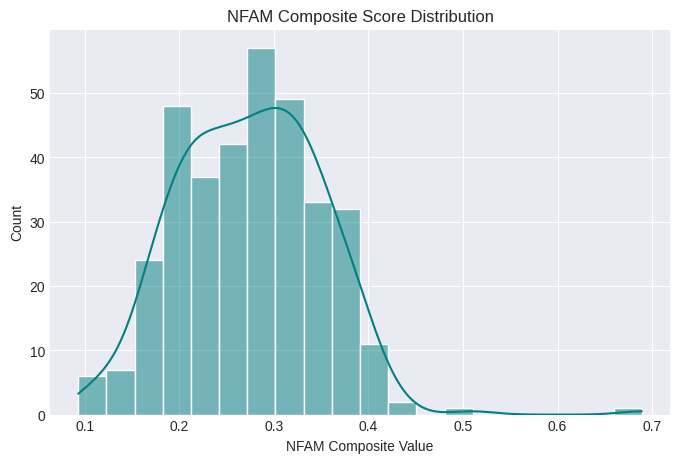

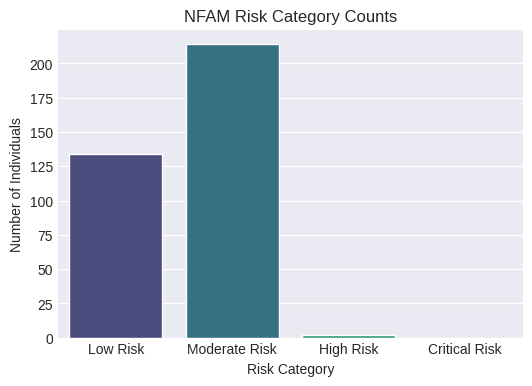

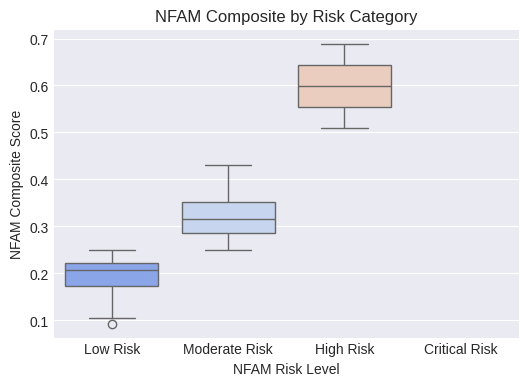

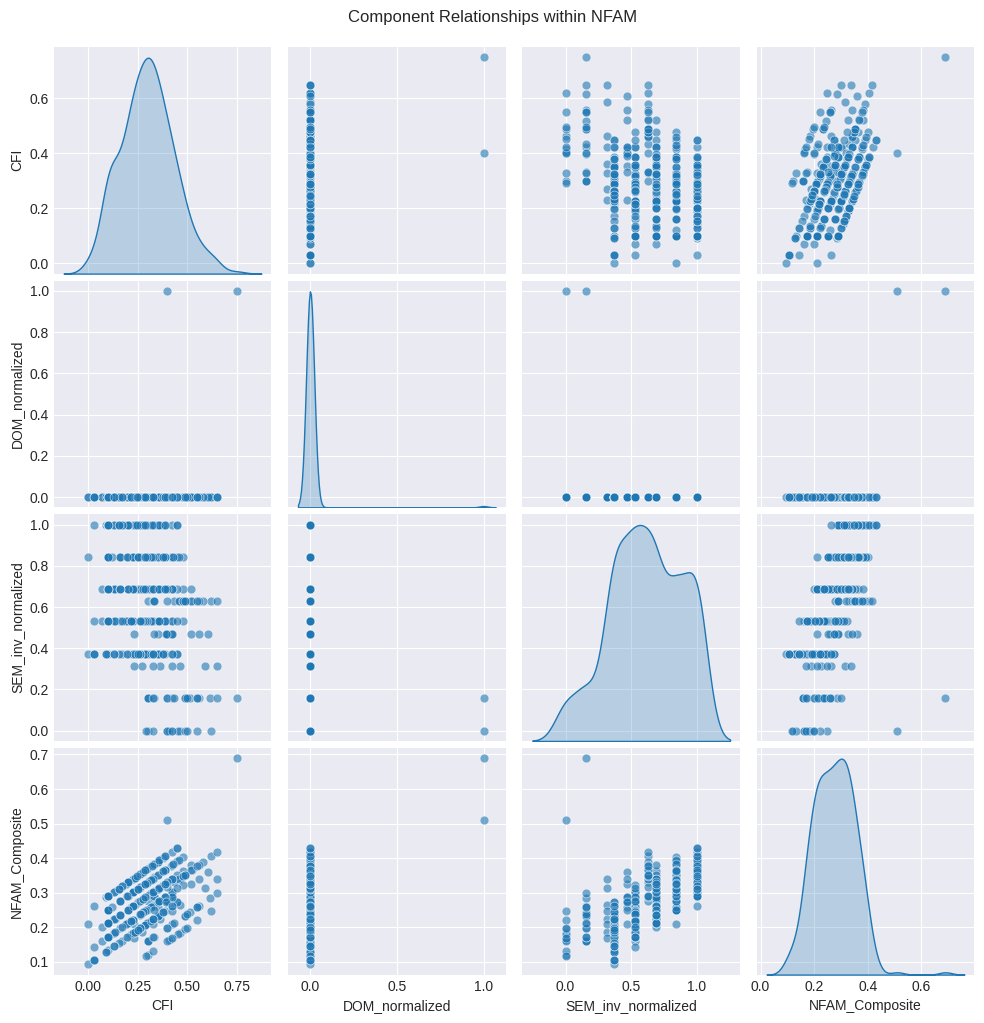

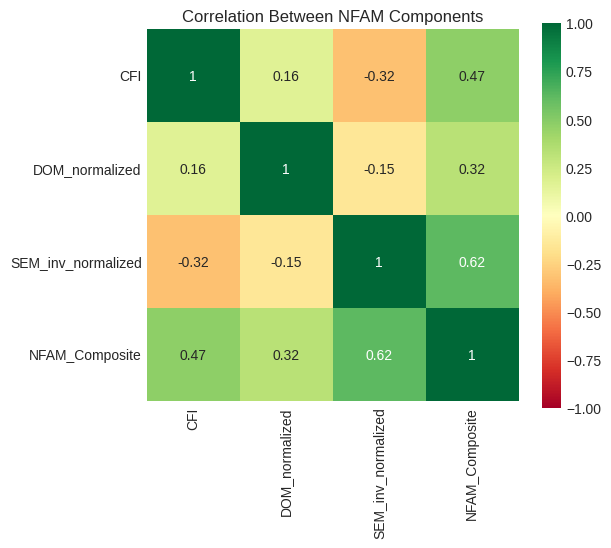

In [ ]:
# ========================================
# STEP 7 Visualization: NFAM Analysis
# ========================================
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-darkgrid")

# --- 1️⃣ Distribution of NFAM Composite
plt.figure(figsize=(8,5))
sns.histplot(df_norm['NFAM_Composite'], kde=True, color='teal', bins=20)
plt.title("NFAM Composite Score Distribution")
plt.xlabel("NFAM Composite Value")
plt.ylabel("Count")
plt.show()

# --- 2️⃣ Risk Category Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='NFAM_Risk', data=df_norm, palette='viridis', order=['Low Risk', 'Moderate Risk', 'High Risk', 'Critical Risk'])
plt.title("NFAM Risk Category Counts")
plt.xlabel("Risk Category")
plt.ylabel("Number of Individuals")
plt.show()

# --- 3️⃣ Boxplot for Visual Variability
plt.figure(figsize=(6,4))
sns.boxplot(x='NFAM_Risk', y='NFAM_Composite', data=df_norm, palette='coolwarm',
            order=['Low Risk', 'Moderate Risk', 'High Risk', 'Critical Risk'])
plt.title("NFAM Composite by Risk Category")
plt.xlabel("NFAM Risk Level")
plt.ylabel("NFAM Composite Score")
plt.show()

# --- 4️⃣ Component Relationship Pairplot
sns.pairplot(df_norm[['CFI', 'DOM_normalized', 'SEM_inv_normalized', 'NFAM_Composite']],
             diag_kind='kde', plot_kws={'alpha':0.6, 's':40})
plt.suptitle("Component Relationships within NFAM", y=1.02)
plt.show()

# --- 5️⃣ Correlation Heatmap
plt.figure(figsize=(6,5))
corr = df_norm[['CFI','DOM_normalized','SEM_inv_normalized','NFAM_Composite']].corr()
sns.heatmap(corr, annot=True, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
plt.title("Correlation Between NFAM Components")
plt.show()



STEP 8: BEHAVIORAL ARCHETYPE CLUSTERING (Enhanced)

Optimal number of clusters: 2
Silhouette Score: 0.4588

Cluster Centers:
     CFI  DOM_normalized  SEM_inv_normalized  SleepHours  StudyHours  \
0  0.258          -0.000               0.689       0.502       0.489   
1  0.449           0.026               0.334       0.537       0.504   

   ExerciseHabit  ScreenTime  
0          0.495        -0.0  
1          0.467         1.0  

✓ Clustering complete
  2 behavioral archetypes identified

Archetype Distribution:
  Moderate Risk            : 274 ( 78.3%)
  Moderate Risk            :  76 ( 21.7%)


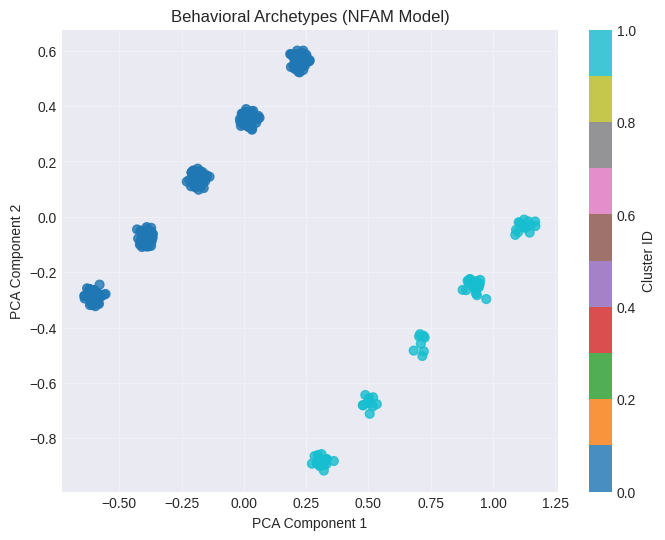


✓ PCA visualization complete — each color represents a behavioral archetype.


In [ ]:
# ========================================
# STEP 8: BEHAVIORAL ARCHETYPE CLUSTERING (Enhanced)
# ========================================
# A qualitative clustering based on lifestyle and cognitive variables
# Explains why the fatigue occurred — the underlying behavioral cause
print("\n" + "="*80)
print("STEP 8: BEHAVIORAL ARCHETYPE CLUSTERING (Enhanced)")
print("="*80)

# Enrich clustering features to capture behavioral diversity
features_for_clustering = [
    'CFI', 'DOM_normalized', 'SEM_inv_normalized',
    'SleepHours', 'StudyHours', 'ExerciseHabit', 'ScreenTime'
]

# Keep only available columns (for safety)
X_cluster = df_norm[[c for c in features_for_clustering if c in df_norm.columns]].copy()

# Fill any remaining missing values
X_cluster = X_cluster.fillna(X_cluster.median())

# ----------------------------------------
# Determine optimal number of clusters
# ----------------------------------------
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np

silhouette_scores = []
k_range = range(2, 8)

for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X_cluster)
    silhouette_scores.append(silhouette_score(X_cluster, labels_temp))

optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")
print(f"Silhouette Score: {max(silhouette_scores):.4f}")

# ----------------------------------------
# Final Clustering
# ----------------------------------------
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_norm['Archetype'] = kmeans.fit_predict(X_cluster)

# Cluster centers
centers = pd.DataFrame(kmeans.cluster_centers_, columns=X_cluster.columns)
print("\nCluster Centers:")
print(centers.round(3))

# ----------------------------------------
# Dynamic Naming Based on Behavioral Patterns
# ----------------------------------------
def name_from_center(c):
    if c['CFI'] > 0.6 and c['DOM_normalized'] > 0.6:
        return "Digitally Overwhelmed"
    elif c['CFI'] > 0.6 and c['SEM_inv_normalized'] > 0.6:
        return "Burnt-Out Striver"
    elif c['ExerciseHabit'] > 0.6 and c['SEM_inv_normalized'] < 0.4:
        return "Balanced Achiever"
    elif c['ScreenTime'] > 0.7 and c['StudyHours'] < 0.4:
        return "Distracted Learner"
    elif c['CFI'] < 0.4 and c['SEM_inv_normalized'] < 0.4:
        return "Calm Performer"
    else:
        return "Moderate Risk"

archetype_name_map = {i: name_from_center(c) for i, c in centers.iterrows()}
df_norm['Archetype_Name'] = df_norm['Archetype'].map(archetype_name_map)

# ----------------------------------------
# Cluster Statistics
# ----------------------------------------
print(f"\n✓ Clustering complete")
print(f"  {optimal_k} behavioral archetypes identified")

print("\nArchetype Distribution:")
for arch_id, name in archetype_name_map.items():
    count = (df_norm['Archetype'] == arch_id).sum()
    print(f"  {name:25s}: {count:3d} ({count/len(df_norm)*100:5.1f}%)")

# ----------------------------------------
# PCA Visualization
# ----------------------------------------
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_norm['Archetype'], cmap='tab10', s=40, alpha=0.8)
plt.title("Behavioral Archetypes (NFAM Model)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster ID')
plt.grid(alpha=0.3)
plt.show()

print("\n✓ PCA visualization complete — each color represents a behavioral archetype.")


Archetype	Behavioral pattern	Why NFAM ≈ Moderate

Cluster 1 — “Tech-Tired Balancers”	Medium CFI, medium DOM, moderate SEM → They manage stress but still screen a lot	Balanced habits offset digital strain

Cluster 2 — “Under-Rested Strivers”	High CFI, low DOM, high SEM → They work/study too hard, but don’t relax digitally	Cognitive load drives same fatigue outcome

In [ ]:
print(archetype_profiles)


                CFI  DOM_normalized  SEM_inv_normalized Archetype_Name
Archetype                                                             
0          0.334158          0.0107            0.402380  Moderate Risk
1          0.259706          0.0000            0.852801  Moderate Risk


In [ ]:
# ========================================
# STEP 9: Predictive Modeling
# ========================================
print("\n" + "="*80)
print("STEP 9: PREDICTIVE MODELING")
print("="*80)

# Create target variable
def create_risk_target(nfam_score):
    if nfam_score < 0.25:
        return 0
    elif nfam_score < 0.50:
        return 1
    elif nfam_score < 0.70:
        return 2
    else:
        return 3

df_norm['RiskLevel'] = df_norm['NFAM_Composite'].apply(create_risk_target)

# Prepare features and split
X = df_norm[['CFI', 'DOM_normalized', 'SEM_inv_normalized']].copy()
y = df_norm['RiskLevel'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set:     {len(X_test)} samples")

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')

print(f"\n✓ Random Forest trained")
print(f"  Accuracy: {acc_rf:.4f} ({acc_rf*100:.2f}%)")
print(f"  CV Accuracy: {cv_scores_rf.mean():.4f} (±{cv_scores_rf.std():.4f})")

# Train XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                              random_state=42, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
cv_scores_xgb = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')

print(f"\n✓ XGBoost trained")
print(f"  Accuracy: {acc_xgb:.4f} ({acc_xgb*100:.2f}%)")
print(f"  CV Accuracy: {cv_scores_xgb.mean():.4f} (±{cv_scores_xgb.std():.4f})")

# Select best model
best_model = xgb_model if acc_xgb > acc_rf else rf_model
best_model_name = 'XGBoost' if acc_xgb > acc_rf else 'Random Forest'
df_norm['Predicted_RiskLevel'] = best_model.predict(X)

print(f"\n✓ Best Model: {best_model_name}")



STEP 9: PREDICTIVE MODELING

Training set: 280 samples
Test set:     70 samples

✓ Random Forest trained
  Accuracy: 0.9857 (98.57%)
  CV Accuracy: 0.9771 (±0.0146)

✓ XGBoost trained
  Accuracy: 0.9857 (98.57%)
  CV Accuracy: 0.9771 (±0.0070)

✓ Best Model: Random Forest


In [63]:
!pip install lime

In [66]:
# ===========================
# STEP 10: DETAILED LIME EXPLAINABILITY REPORTS
# ===========================
# Requirements:
# pip install lime

import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
from sklearn.preprocessing import StandardScaler

# -------------------------
# 0. Choose model automatically (tries these names in order)
# -------------------------
model = None
for candidate in ['best_model', 'xgb_model', 'rf_model', 'best_classification_model']:
    if candidate in globals():
        model = globals()[candidate]
        print(f"Using model: {candidate}")
        break
if model is None:
    raise RuntimeError("No trained model found in the current namespace. Make sure best_model / xgb_model / rf_model exists.")

# -------------------------
# 1. Data references (adjust if your variable names differ)
# -------------------------
# X_test should be a DataFrame; y_test the corresponding labels
# If your variables are named differently, update these lines accordingly.
X = globals().get('X_test', globals().get('X_test'))  # keep same name if present
y = globals().get('y_test', globals().get('y_test'))
if X is None or y is None:
    raise RuntimeError("X_test or y_test not found. Make sure you have split data as X_test, y_test.")

# If X is numpy array, convert to DataFrame with expected feature names
if isinstance(X, np.ndarray):
    if 'feature_names' in globals():
        feature_names = globals()['feature_names']
    else:
        # fallback: try to get from previous X variable or df_norm columns
        feature_names = list(globals().get('df_norm', pd.DataFrame()).columns)
    X = pd.DataFrame(X, columns=feature_names[:X.shape[1]])
else:
    feature_names = list(X.columns)

# Convert model.predict_proba to a safe predict_fn for LIME
def predict_proba_fn(data_numpy):
    # LIME sends 2D numpy array
    try:
        return model.predict_proba(data_numpy)
    except Exception as e:
        # fallback for models that expect DataFrame
        return model.predict_proba(pd.DataFrame(data_numpy, columns=feature_names))

# -------------------------
# 2. Prepare LIME explainer
# -------------------------
# Use training data for the explainer's background distribution. If not available, use X (test) as fallback.
X_train_for_lime = globals().get('X_train', None)
if X_train_for_lime is None:
    X_train_for_lime = X.copy()

# ensure numpy array for LimeTabularExplainer
train_array = np.array(X_train_for_lime)

class_names = [str(c) for c in np.unique(y)]
lime_explainer = LimeTabularExplainer(
    training_data=train_array,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    discretize_continuous=True
)

# -------------------------
# 3. Utility functions to create human-readable justifications
# -------------------------
# Compute dataset-level context (median, mean, percentiles)
context_stats = {}
for col in feature_names:
    col_vals = pd.to_numeric(X[col], errors='coerce')
    context_stats[col] = {
        'mean': float(col_vals.mean()),
        'median': float(col_vals.median()),
        'std': float(col_vals.std(ddof=0)) if not math.isnan(col_vals.std(ddof=0)) else 0.0,
        'p10': float(col_vals.quantile(0.10)),
        'p25': float(col_vals.quantile(0.25)),
        'p75': float(col_vals.quantile(0.75)),
        'p90': float(col_vals.quantile(0.90))
    }

def format_val(v, sig=3):
    try:
        return f"{v:.{sig}f}"
    except:
        return str(v)

def human_justify(instance_row, lime_list, class_index):
    """
    Build a human-readable justification from LIME contributions.
    - instance_row: pd.Series of feature values for this sample
    - lime_list: list of (feature_name, contribution) from LIME for the target class
    - class_index: integer class predicted/explained
    """
    lines = []
    # header
    pred_class = class_names[class_index]
    lines.append(f"Prediction target (class): {pred_class}")
    lines.append(f"Feature-level contributions (top {len(lime_list)}):")
    for feat, contrib in lime_list:
        val = instance_row[feat]
        stats = context_stats.get(feat, {})
        mean = stats.get('mean', None)
        # direction
        direction = "increases" if contrib > 0 else "decreases"
        # relative to mean/percentiles
        rel = ""
        if mean is not None and not math.isnan(mean):
            diff = val - mean
            pct = (diff / mean * 100) if mean != 0 else np.nan
            rel = f" (value={format_val(val)}, mean={format_val(mean)}, diff={format_val(diff)}; {format_val(pct)}% vs mean)"
        lines.append(f" • {feat}: {direction} predicted probability by {format_val(contrib)}{rel}")
    # summary suggestion
    lines.append("\nSuggested interpretation:")
    pos_feats = [f for f, c in lime_list if c > 0]
    neg_feats = [f for f, c in lime_list if c < 0]
    if pos_feats:
        lines.append(f" - Primary risk drivers: {', '.join(pos_feats)}.")
    if neg_feats:
        lines.append(f" - Protective/mitigating factors: {', '.join(neg_feats)}.")
    # short recommendation template
    recs = []
    for f, c in lime_list:
        if c > 0:
            recs.append(f"Reduce {f}")
        else:
            recs.append(f"Maintain or strengthen {f}")
    lines.append("\nActionable suggestions (automatically generated):")
    for r in recs[:5]:
        lines.append(" - " + r)
    return "\n".join(lines)

# -------------------------
# 4. Explain a list of sample indices (one-by-one) with LIME and save HTML + text justification
# -------------------------
output_dir = "lime_reports"
os.makedirs(output_dir, exist_ok=True)

def explain_samples_with_lime(sample_indices, class_to_explain=None, num_features=8):
    """
    Explain provided sample indices (list) using LIME.
    class_to_explain: if None, use model.predict to pick predicted class.
    """
    reports = {}
    # Ensure indices are valid for the test set
    valid_indices = [idx for idx in sample_indices if idx in X.index]
    if len(valid_indices) != len(sample_indices):
        print(f"⚠️ Warning: Some selected sample indices were not found in the test set.")
        sample_indices = valid_indices
        if not sample_indices:
            print("No valid sample indices to explain.")
            return reports

    for idx in sample_indices:
        instance = X.loc[idx] # Use .loc for label-based indexing
        instance_np = instance.values

        # If class not given, use model.predicted class for this sample
        if class_to_explain is None:
            pred_probs = predict_proba_fn(instance_np.reshape(1, -1))[0]
            pred_class = int(np.argmax(pred_probs))
        else:
            pred_class = class_to_explain

        # LIME explanation
        lime_exp = lime_explainer.explain_instance(
            data_row=instance_np,
            predict_fn=predict_proba_fn,
            num_features=num_features,
            top_labels=None
        )

        # get local explanation for target class
        local_exp = lime_exp.as_map()  # dict: class->list of (feature_idx, contribution)
        if pred_class in local_exp:
            raw = local_exp[pred_class]
        else:
            # pick the class with largest probability if pred_class absent
            raw = local_exp[next(iter(local_exp))]

        # convert to (feature_name, contribution)
        lime_list = []
        for feat_idx, contrib in raw:
            fname = feature_names[feat_idx]
            lime_list.append((fname, contrib))

        # Human justification textual summary
        justification_text = human_justify(instance, lime_list, pred_class)

        # Save HTML widget for visualization
        html_path = os.path.join(output_dir, f"lime_sample_{idx}_class{pred_class}.html")
        lime_exp.save_to_file(html_path)

        # store report
        reports[idx] = {
            'index': idx,
            'pred_class': pred_class,
            'pred_probs': predict_proba_fn(instance_np.reshape(1,-1))[0].tolist(),
            'lime_list': lime_list,
            'justification': justification_text,
            'html_report': html_path
        }

        # Print compact summary to notebook
        print("\n" + "-"*80)
        print(f"SAMPLE {idx} — predicted class: {class_names[pred_class]}  — probs: {reports[idx]['pred_probs']}")
        print("-" * 80)
        print(justification_text)
        print(f"\nHTML saved: {html_path}")
        print("-" * 80)
    return reports

# -------------------------
# 5. Choose representative samples for each NFAM risk level and each archetype (if available)
# -------------------------
# Representative selection strategy:
#  - For each RiskLevel (0..3) pick the sample with the highest predicted probability for that class.
#  - For each Archetype, pick the cluster centroid nearest sample (if archetype exists).

reports_all = {}

# a) by RiskLevel (selecting from X_test indices)
if 'RiskLevel' in df_norm.columns:
    # Filter df_norm to match the indices of X_test
    df_norm_test = df_norm.loc[X.index]
    for rl in sorted(df_norm_test['RiskLevel'].unique()):
        # compute predicted probabilities for the class using the model trained on X_train/y_train
        probs = predict_proba_fn(np.array(X))
        class_probs = np.array(probs)[:, rl]
        # pick index from X (test set indices) with max probability for this class
        # Filter to only consider indices that *actually* belong to this RiskLevel in the test set
        relevant_indices = df_norm_test[df_norm_test['RiskLevel'] == rl].index
        if not relevant_indices.empty:
            # Find the index within X_test's original index that has the highest probability for this class
            max_prob_idx_in_X = np.argmax(class_probs[X.index.isin(relevant_indices)])
            # Get the actual index value from the original df_norm
            actual_idx = X.index[X.index.isin(relevant_indices)][max_prob_idx_in_X]
            reports_all[f"risklevel_{rl}"] = actual_idx


# b) by Archetype (if exists, selecting from X_test indices)
if 'Archetype' in df_norm.columns:
    archetypes = sorted(df_norm['Archetype'].unique())
    # find one sample per archetype: nearest to centroid (using features used for clustering if available)
    cluster_feat_cols = [c for c in ['CFI', 'DOM_normalized', 'SEM_inv_normalized', 'StudyHours', 'SleepHours'] if c in df_norm.columns]
    if cluster_feat_cols:
        # Filter df_norm to only consider the test set indices
        df_norm_test = df_norm.loc[X.index]
        # Use the original df_norm to calculate centroids if needed, but select samples from df_norm_test
        centers_full = df_norm.groupby('Archetype')[cluster_feat_cols].mean()
        for arch_id in archetypes:
            # Find indices for this archetype that are also in the test set
            idxs_in_test_set = df_norm_test[df_norm_test['Archetype'] == arch_id].index
            if len(idxs_in_test_set) == 0:
                continue
            # Use the centroid calculated from the full dataset
            centroid = centers_full.loc[arch_id].values
            # Compute distances for samples in the test set that belong to this archetype
            arr = df_norm_test.loc[idxs_in_test_set, cluster_feat_cols].values
            dists = np.linalg.norm(arr - centroid.reshape(1, -1), axis=1)
            # Find the index within the test set indices that is closest to the centroid
            nearest_local_idx_in_test_set = np.argmin(dists)
            actual_idx = idxs_in_test_set[nearest_local_idx_in_test_set]
            reports_all[f"archetype_{arch_id}"] = int(actual_idx)

# create unique list of sample indices to explain
sample_indices = sorted(set(reports_all.values()))
print(f"\nSelected sample indices for explanation (from test set): {sample_indices}")

# Run LIME explanation for chosen indices
reports = explain_samples_with_lime(sample_indices, num_features=8)

# Save a CSV summary with short justifications
summary_rows = []
for idx, rep in reports.items():
    summary_rows.append({
        'sample_index': idx,
        'pred_class': rep['pred_class'],
        'pred_probs': rep['pred_probs'],
        'html_report': rep['html_report'],
        'justification_short': rep['justification'].split('\n')[0:6]  # first 6 lines
    })
pd.DataFrame(summary_rows).to_csv(os.path.join(output_dir, 'lime_summary.csv'), index=False)
print(f"\nSaved summary CSV to {os.path.join(output_dir, 'lime_summary.csv')}")

Using model: best_model

Selected sample indices for explanation (from test set): [np.int64(4), np.int64(54), 280, 287]

--------------------------------------------------------------------------------
SAMPLE 4 — predicted class: 0  — probs: [1.0, 0.0, 0.0]
--------------------------------------------------------------------------------
Prediction target (class): 0
Feature-level contributions (top 3):
 • CFI: decreases predicted probability by -0.349 (value=0.100, mean=0.295, diff=-0.195; -66.140% vs mean)
 • DOM_normalized: increases predicted probability by 0.106 (value=0.000, mean=0.000, diff=-0.000; -100.000% vs mean)
 • SEM_inv_normalized: decreases predicted probability by -0.094 (value=0.530, mean=0.625, diff=-0.096; -15.309% vs mean)

Suggested interpretation:
 - Primary risk drivers: DOM_normalized.
 - Protective/mitigating factors: CFI, SEM_inv_normalized.

Actionable suggestions (automatically generated):
 - Maintain or strengthen CFI
 - Reduce DOM_normalized
 - Maintain or 

In [67]:
# ========================================
# NFAM FRAMEWORK - COMPREHENSIVE VISUALIZATIONS
# Run this after the main analysis
# ========================================

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

print("="*80)
print("GENERATING COMPREHENSIVE VISUALIZATIONS")
print("="*80)

GENERATING COMPREHENSIVE VISUALIZATIONS



[1/7] Generating CFI visualizations...
  ✓ Saved: cfi_analysis.png


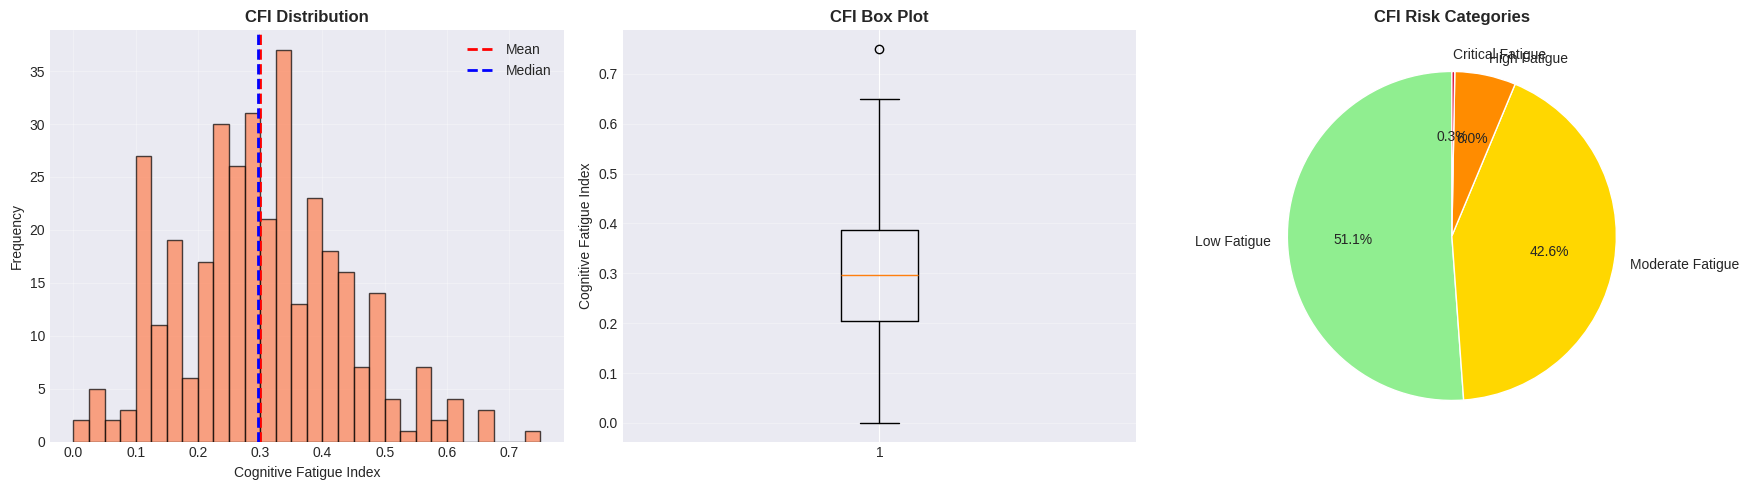

In [68]:
# ========================================
# 1. CFI Analysis Visualizations
# ========================================
print("\n[1/7] Generating CFI visualizations...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(df_norm['CFI'], bins=30, alpha=0.7, color='coral', edgecolor='black')
axes[0].axvline(df_norm['CFI'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].axvline(df_norm['CFI'].median(), color='blue', linestyle='--', linewidth=2, label='Median')
axes[0].set_title('CFI Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Cognitive Fatigue Index')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(df_norm['CFI'], vert=True)
axes[1].set_title('CFI Box Plot', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cognitive Fatigue Index')
axes[1].grid(True, alpha=0.3, axis='y')

# Category pie chart
category_counts = df_norm['CFI_Category'].value_counts()
category_colors = ['#90EE90', '#FFD700', '#FF8C00', '#DC143C']
axes[2].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
            startangle=90, colors=category_colors)
axes[2].set_title('CFI Risk Categories', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('cfi_analysis.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: cfi_analysis.png")

[2/7] Generating DOM visualizations...
  ✓ Saved: dom_analysis.png


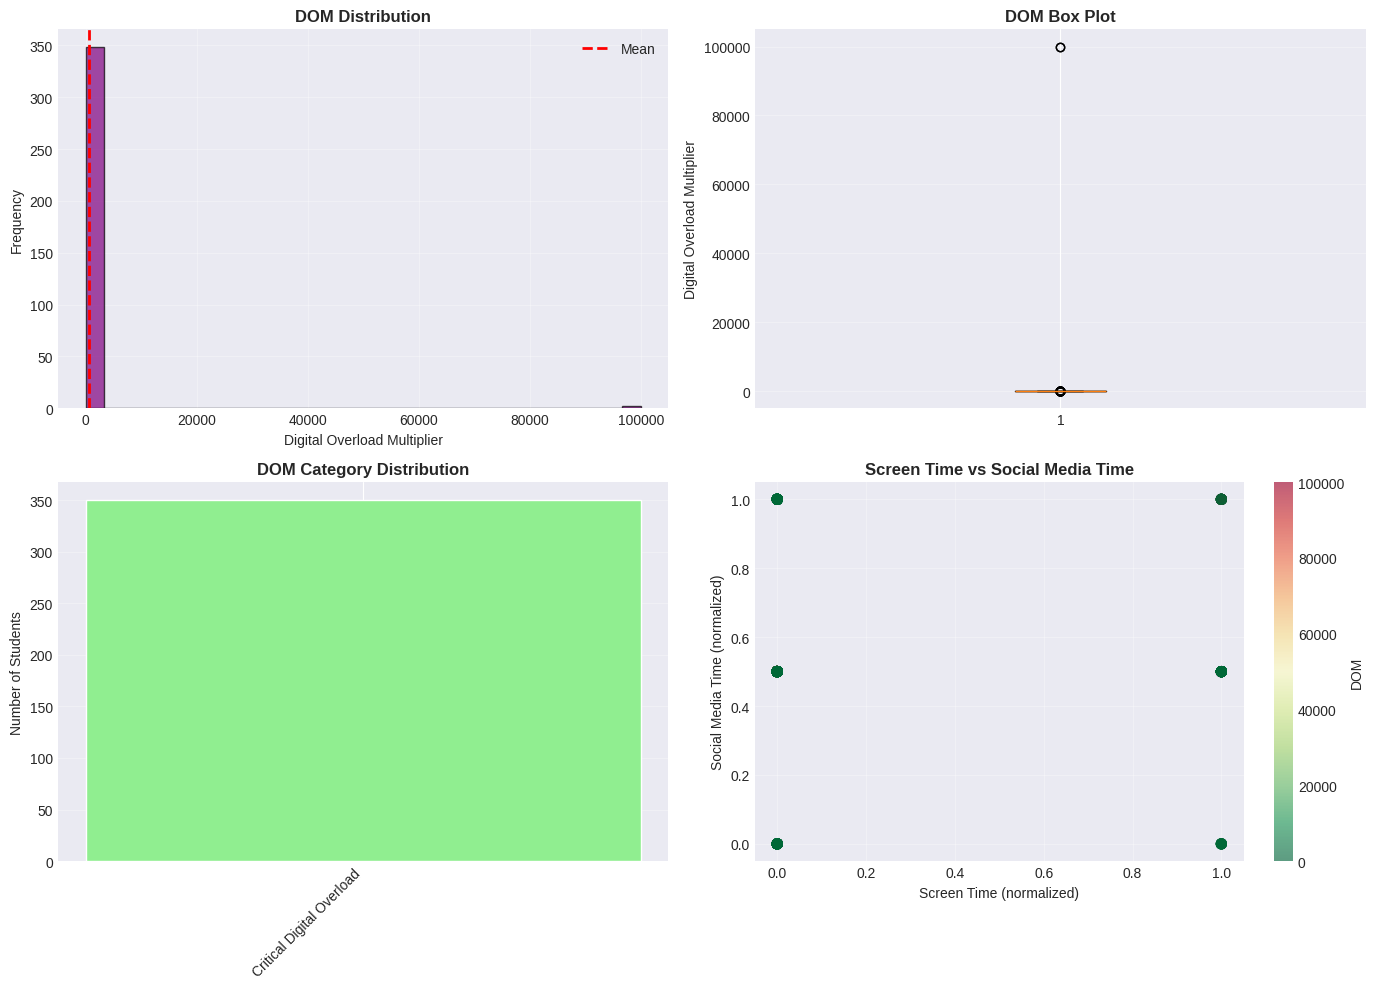

In [69]:
# ========================================
# 2. DOM Analysis Visualizations
# ========================================
print("[2/7] Generating DOM visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram
axes[0, 0].hist(df_norm['DOM'], bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[0, 0].axvline(df_norm['DOM'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 0].set_title('DOM Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Digital Overload Multiplier')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Box plot
axes[0, 1].boxplot(df_norm['DOM'], vert=True)
axes[0, 1].set_title('DOM Box Plot', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Digital Overload Multiplier')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Category distribution
category_counts = df_norm['DOM_Category'].value_counts()
axes[1, 0].bar(range(len(category_counts)), category_counts.values, color=category_colors)
axes[1, 0].set_xticks(range(len(category_counts)))
axes[1, 0].set_xticklabels(category_counts.index, rotation=45, ha='right')
axes[1, 0].set_title('DOM Category Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of Students')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Scatter: Screen Time vs Social Media
scatter = axes[1, 1].scatter(df_norm['ScreenTime'], df_norm['SocialMediaTime'],
                             c=df_norm['DOM'], cmap='RdYlGn_r', alpha=0.6, s=50)
axes[1, 1].set_title('Screen Time vs Social Media Time', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Screen Time (normalized)')
axes[1, 1].set_ylabel('Social Media Time (normalized)')
plt.colorbar(scatter, ax=axes[1, 1], label='DOM')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dom_analysis.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: dom_analysis.png")


[3/7] Generating SEM visualizations...
  ✓ Saved: sem_analysis.png


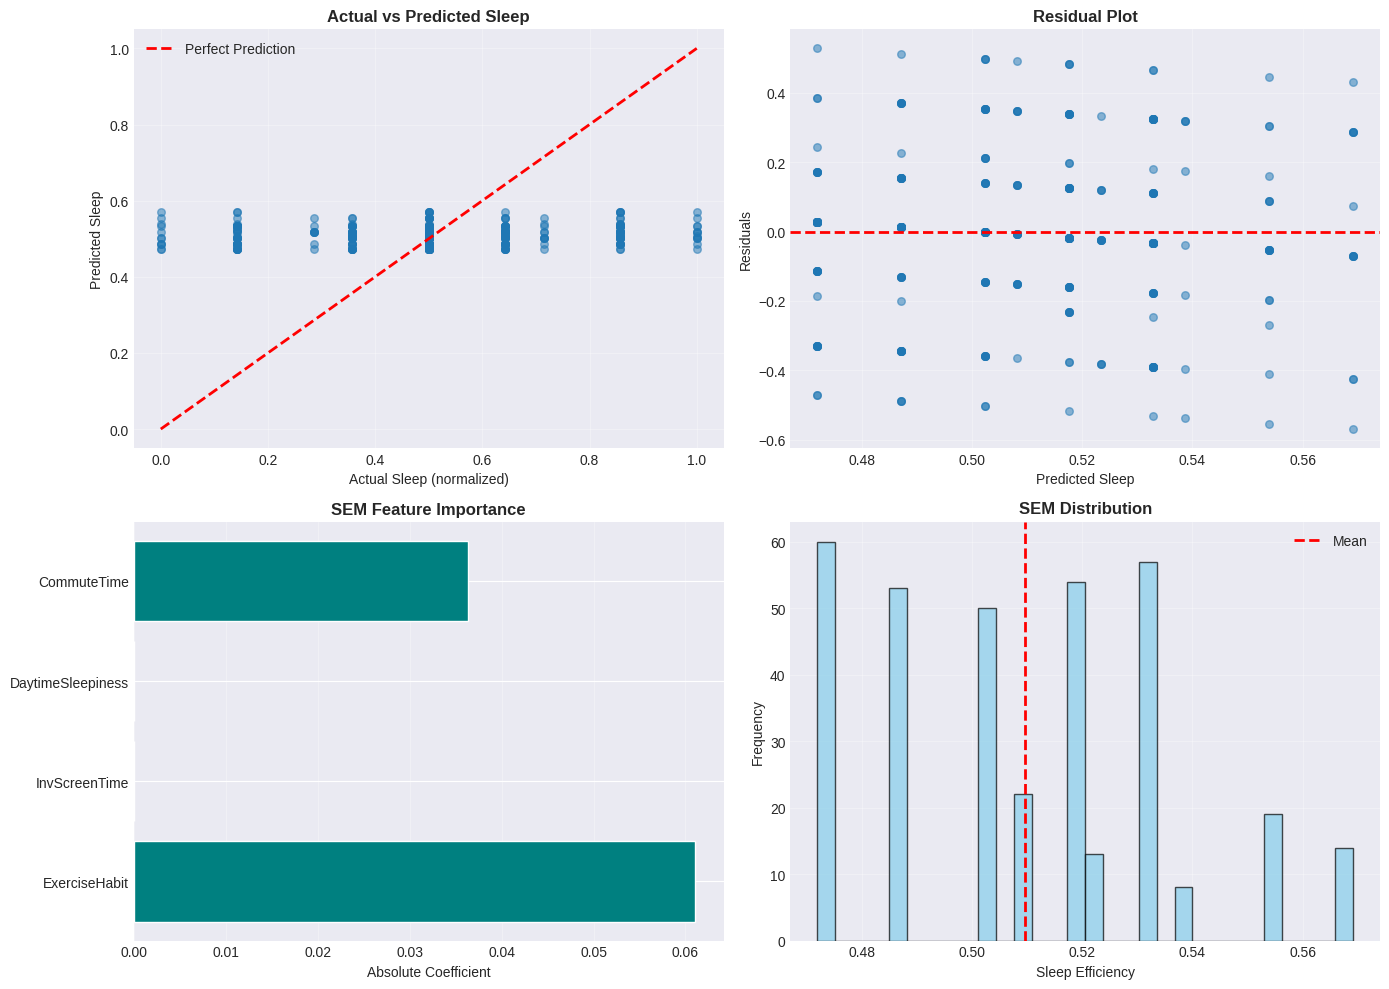

In [77]:
# ========================================
# 3. SEM Analysis Visualizations (Fixed)
# ========================================
print("[3/7] Generating SEM visualizations...")

import numpy as np
import matplotlib.pyplot as plt

# --- Ensure y_sem and predicted values are 1D arrays ---
# y_sem: actual target
# df_norm['SEM_PredictedSleep']: predicted from model
y_sem = np.ravel(y_sem)  # flattens to 1D
y_pred_sem = np.ravel(df_norm['SEM_PredictedSleep'])

# --- Create plots ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- 1. Actual vs Predicted ---
axes[0, 0].scatter(y_sem, y_pred_sem, alpha=0.5, s=30)
axes[0, 0].plot(
    [y_sem.min(), y_sem.max()],
    [y_sem.min(), y_sem.max()],
    'r--',
    linewidth=2,
    label='Perfect Prediction'
)
axes[0, 0].set_title('Actual vs Predicted Sleep', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Actual Sleep (normalized)')
axes[0, 0].set_ylabel('Predicted Sleep')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# --- 2. Residuals ---
residuals = y_sem - y_pred_sem
axes[0, 1].scatter(y_pred_sem, residuals, alpha=0.5, s=30)
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Predicted Sleep')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].grid(True, alpha=0.3)

# --- 3. Feature Coefficients ---
feature_names = ['ExerciseHabit', 'InvScreenTime', 'DaytimeSleepiness', 'CommuteTime']
coefficients = np.abs(np.ravel(sem_model.coef_))
axes[1, 0].barh(feature_names, coefficients, color='teal')
axes[1, 0].set_title('SEM Feature Importance', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Absolute Coefficient')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# --- 4. SEM Distribution ---
axes[1, 1].hist(df_norm['SEM'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 1].axvline(df_norm['SEM'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[1, 1].set_title('SEM Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Sleep Efficiency')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sem_analysis.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: sem_analysis.png")


[4/7] Generating NFAM composite visualizations...
  ✓ Saved: nfam_composite_analysis.png


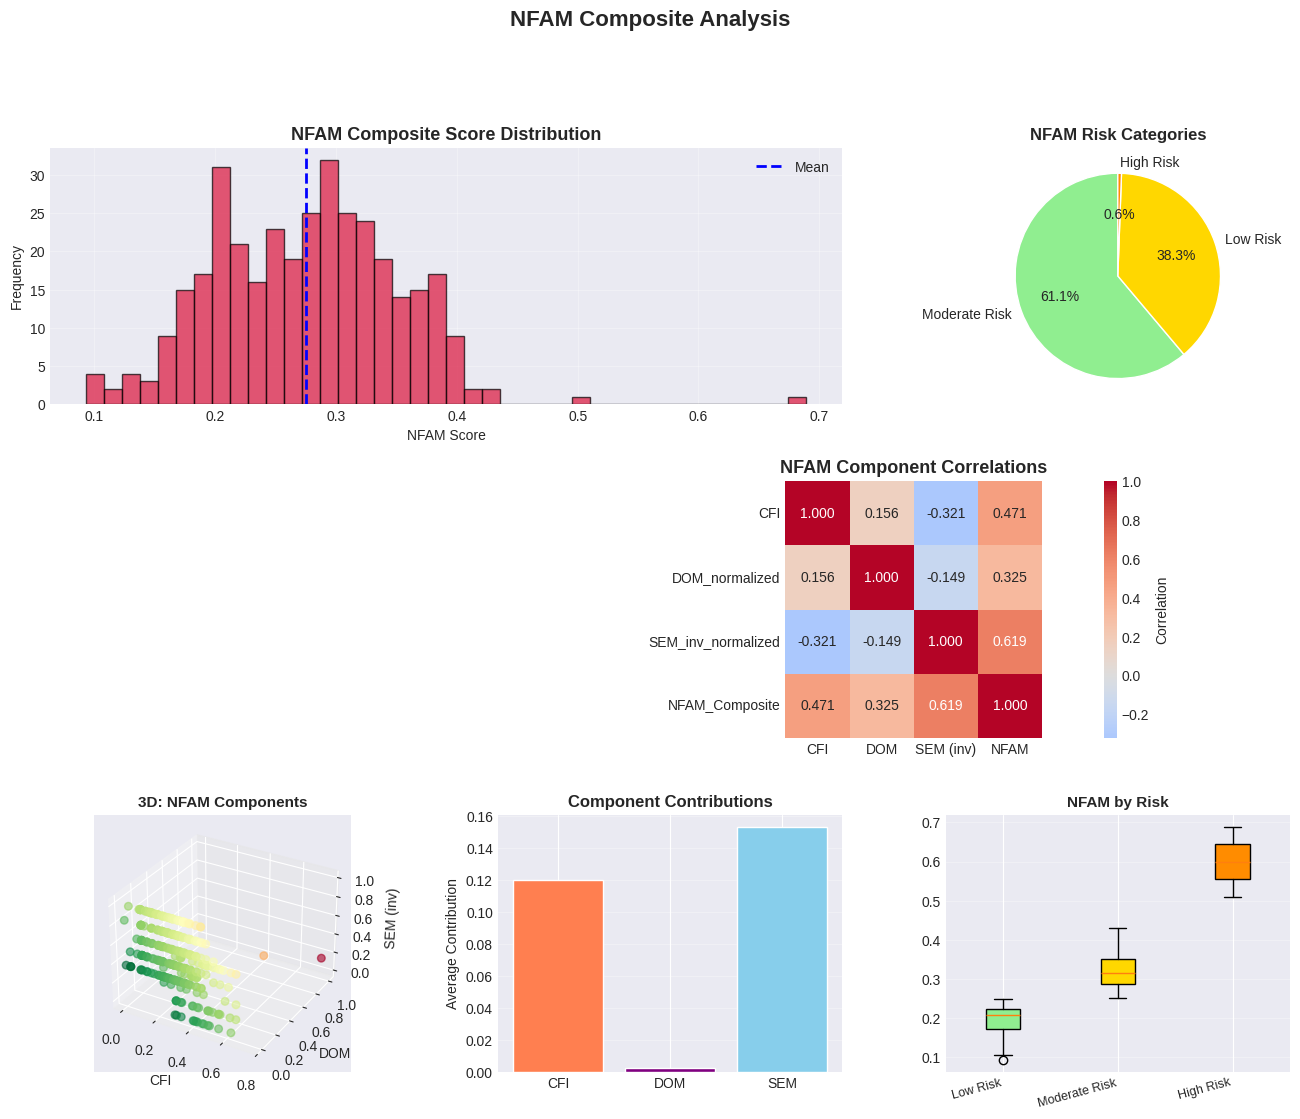

In [78]:
# ========================================
# 4. NFAM Composite Visualizations
# ========================================
print("[4/7] Generating NFAM composite visualizations...")

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# NFAM Distribution
ax1 = fig.add_subplot(gs[0, :2])
ax1.hist(df_norm['NFAM_Composite'], bins=40, alpha=0.7, color='crimson', edgecolor='black')
ax1.axvline(df_norm['NFAM_Composite'].mean(), color='blue', linestyle='--', linewidth=2, label='Mean')
ax1.set_title('NFAM Composite Score Distribution', fontsize=13, fontweight='bold')
ax1.set_xlabel('NFAM Score')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Risk pie chart
ax2 = fig.add_subplot(gs[0, 2])
risk_counts = df_norm['NFAM_Risk'].value_counts()
risk_colors = ['#90EE90', '#FFD700', '#FF8C00', '#DC143C']
ax2.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%',
        startangle=90, colors=risk_colors)
ax2.set_title('NFAM Risk Categories', fontsize=12, fontweight='bold')

# Correlation heatmap
ax3 = fig.add_subplot(gs[1, :])
corr_vars = ['CFI', 'DOM_normalized', 'SEM_inv_normalized', 'NFAM_Composite']
corr_matrix = df_norm[corr_vars].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True,
            ax=ax3, fmt='.3f', cbar_kws={'label': 'Correlation'})
ax3.set_title('NFAM Component Correlations', fontsize=13, fontweight='bold')
ax3.set_xticklabels(['CFI', 'DOM', 'SEM (inv)', 'NFAM'], rotation=0)

# 3D scatter
ax4 = fig.add_subplot(gs[2, 0], projection='3d')
scatter = ax4.scatter(df_norm['CFI'], df_norm['DOM_normalized'],
                      df_norm['SEM_inv_normalized'],
                      c=df_norm['NFAM_Composite'], cmap='RdYlGn_r', s=30, alpha=0.6)
ax4.set_xlabel('CFI')
ax4.set_ylabel('DOM')
ax4.set_zlabel('SEM (inv)')
ax4.set_title('3D: NFAM Components', fontsize=11, fontweight='bold')

# Component contributions
ax5 = fig.add_subplot(gs[2, 1])
components = ['CFI', 'DOM', 'SEM']
contributions = [0.40 * df_norm['CFI'].mean(),
                0.35 * df_norm['DOM_normalized'].mean(),
                0.25 * df_norm['SEM_inv_normalized'].mean()]
bars = ax5.bar(components, contributions, color=['coral', 'purple', 'skyblue'])
ax5.set_title('Component Contributions', fontsize=12, fontweight='bold')
ax5.set_ylabel('Average Contribution')
ax5.grid(True, alpha=0.3, axis='y')

# Risk level boxplots
ax6 = fig.add_subplot(gs[2, 2])
risk_order = ['Low Risk', 'Moderate Risk', 'High Risk', 'Critical Risk']
risk_data = [df_norm[df_norm['NFAM_Risk'] == risk]['NFAM_Composite'].values
             for risk in risk_order if risk in df_norm['NFAM_Risk'].values]
bp = ax6.boxplot(risk_data, labels=[r for r in risk_order if r in df_norm['NFAM_Risk'].values],
                 patch_artist=True)
for patch, color in zip(bp['boxes'], risk_colors):
    patch.set_facecolor(color)
ax6.set_title('NFAM by Risk', fontsize=11, fontweight='bold')
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=15, ha='right', fontsize=9)
ax6.grid(True, alpha=0.3, axis='y')

plt.suptitle('NFAM Composite Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('nfam_composite_analysis.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: nfam_composite_analysis.png")

[5/7] Generating archetype visualizations...
  ✓ Saved: behavioral_archetypes.png


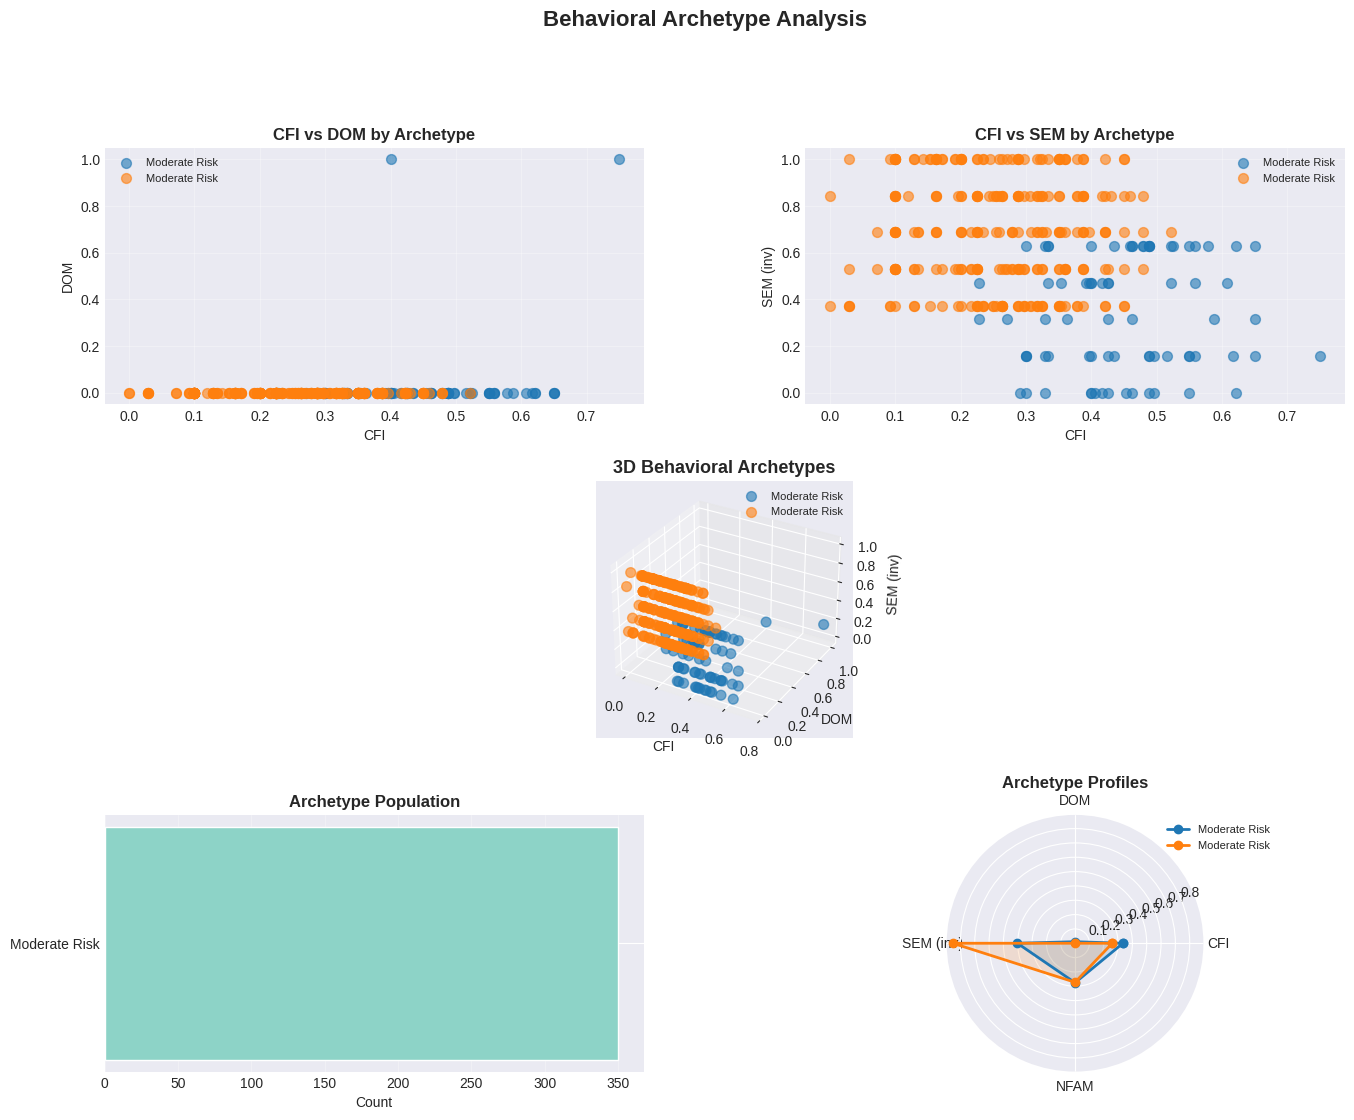

In [79]:
# ========================================
# 5. Behavioral Archetypes Visualizations
# ========================================
print("[5/7] Generating archetype visualizations...")

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 2D: CFI vs DOM
ax1 = fig.add_subplot(gs[0, 0])
for arch in df_norm['Archetype'].unique():
    arch_data = df_norm[df_norm['Archetype'] == arch]
    ax1.scatter(arch_data['CFI'], arch_data['DOM_normalized'],
               label=archetype_name_map[arch], s=50, alpha=0.6)
ax1.set_title('CFI vs DOM by Archetype', fontsize=12, fontweight='bold')
ax1.set_xlabel('CFI')
ax1.set_ylabel('DOM')
ax1.legend(loc='best', fontsize=8)
ax1.grid(True, alpha=0.3)

# 2D: CFI vs SEM
ax2 = fig.add_subplot(gs[0, 1])
for arch in df_norm['Archetype'].unique():
    arch_data = df_norm[df_norm['Archetype'] == arch]
    ax2.scatter(arch_data['CFI'], arch_data['SEM_inv_normalized'],
               label=archetype_name_map[arch], s=50, alpha=0.6)
ax2.set_title('CFI vs SEM by Archetype', fontsize=12, fontweight='bold')
ax2.set_xlabel('CFI')
ax2.set_ylabel('SEM (inv)')
ax2.legend(loc='best', fontsize=8)
ax2.grid(True, alpha=0.3)

# 3D scatter
ax3 = fig.add_subplot(gs[1, :], projection='3d')
for arch in df_norm['Archetype'].unique():
    arch_data = df_norm[df_norm['Archetype'] == arch]
    ax3.scatter(arch_data['CFI'], arch_data['DOM_normalized'],
               arch_data['SEM_inv_normalized'],
               label=archetype_name_map[arch], s=50, alpha=0.6)
ax3.set_xlabel('CFI')
ax3.set_ylabel('DOM')
ax3.set_zlabel('SEM (inv)')
ax3.set_title('3D Behavioral Archetypes', fontsize=13, fontweight='bold')
ax3.legend(loc='best', fontsize=8)

# Population distribution
ax4 = fig.add_subplot(gs[2, 0])
arch_counts = df_norm['Archetype_Name'].value_counts()
bars = ax4.barh(arch_counts.index, arch_counts.values, color=plt.cm.Set3(range(len(arch_counts))))
ax4.set_title('Archetype Population', fontsize=12, fontweight='bold')
ax4.set_xlabel('Count')
ax4.grid(True, alpha=0.3, axis='x')

# Radar chart
ax5 = fig.add_subplot(gs[2, 1], projection='polar')
categories = ['CFI', 'DOM', 'SEM (inv)', 'NFAM']
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

for arch_id, name in archetype_name_map.items():
    values = archetype_profiles.loc[arch_id, ['CFI', 'DOM_normalized',
                                               'SEM_inv_normalized']].tolist()
    values.append(df_norm[df_norm['Archetype']==arch_id]['NFAM_Composite'].mean())
    values += values[:1]
    ax5.plot(angles, values, 'o-', linewidth=2, label=name)
    ax5.fill(angles, values, alpha=0.15)

ax5.set_xticks(angles[:-1])
ax5.set_xticklabels(categories)
ax5.set_title('Archetype Profiles', fontsize=12, fontweight='bold', pad=20)
ax5.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=8)

plt.suptitle('Behavioral Archetype Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('behavioral_archetypes.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: behavioral_archetypes.png")

[6/7] Generating model performance visualizations...
  ✓ Saved: predictive_model_analysis.png


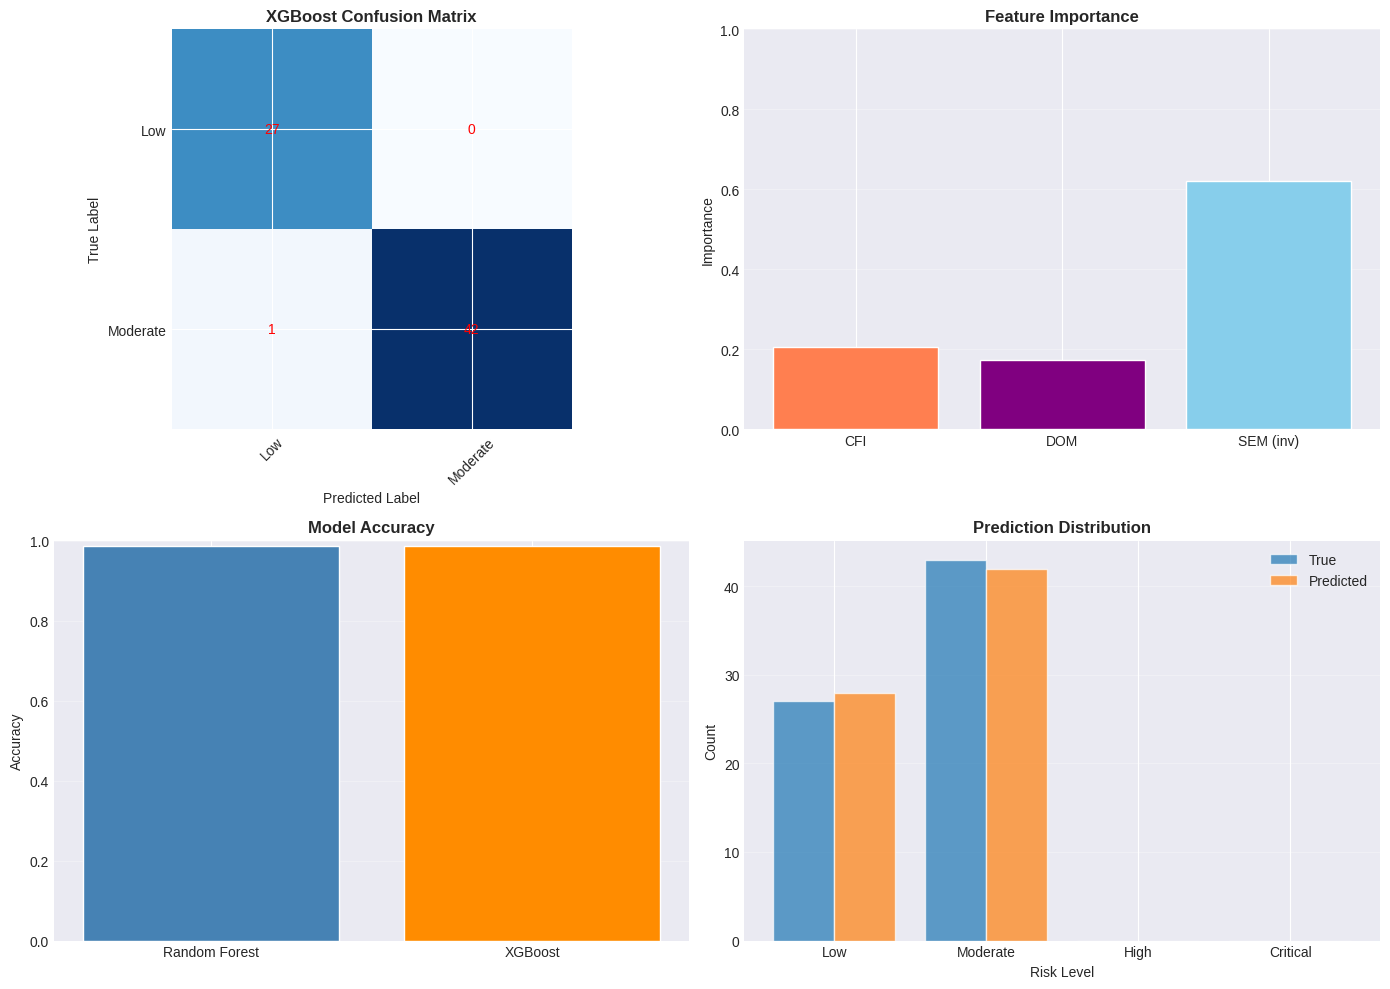

In [81]:
# ========================================
# 6. Model Performance Visualizations
# ========================================
print("[6/7] Generating model performance visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Confusion Matrix - XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Get unique classes from test data
unique_classes = np.unique(np.concatenate((y_test, y_pred_xgb)))
# Map class indices to descriptive names if possible, fallback to index
try:
    # Assuming class names are ordered 0, 1, 2, 3 corresponding to Low, Moderate, High, Critical
    full_risk_names = ['Low', 'Moderate', 'High', 'Critical']
    risk_names_present = [full_risk_names[i] for i in unique_classes]
except IndexError:
     # Fallback if class indices don't directly map to full_risk_names
     risk_names_present = [str(i) for i in unique_classes]


im1 = axes[0, 0].imshow(cm_xgb, interpolation='nearest', cmap='Blues')
axes[0, 0].set_title('XGBoost Confusion Matrix', fontsize=12, fontweight='bold')

tick_marks = np.arange(len(unique_classes))
axes[0, 0].set_xticks(tick_marks)
axes[0, 0].set_yticks(tick_marks)
axes[0, 0].set_xticklabels(risk_names_present, rotation=45)
axes[0, 0].set_yticklabels(risk_names_present)
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')

# Add counts to the confusion matrix
# Iterate based on the actual dimensions of the confusion matrix
for i in range(cm_xgb.shape[0]):
    for j in range(cm_xgb.shape[1]):
        axes[0, 0].text(j, i, str(cm_xgb[i, j]), ha='center', va='center', color='red')

# Feature importance
axes[0, 1].bar(['CFI', 'DOM', 'SEM (inv)'], xgb_model.feature_importances_,
               color=['coral', 'purple', 'skyblue'])
axes[0, 1].set_title('Feature Importance', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Importance')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Model comparison
axes[1, 0].bar(['Random Forest', 'XGBoost'], [acc_rf, acc_xgb],
               color=['steelblue', 'darkorange'])
axes[1, 0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Prediction distribution
axes[1, 1].hist([y_test, y_pred_xgb], label=['True', 'Predicted'], bins=np.arange(len(full_risk_names) + 1) - 0.5, alpha=0.7)
axes[1, 1].set_title('Prediction Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Risk Level')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_xticks(np.arange(len(full_risk_names)))
axes[1, 1].set_xticklabels(full_risk_names)


plt.tight_layout()
plt.savefig('predictive_model_analysis.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: predictive_model_analysis.png")

[7/7] Generating comprehensive summary dashboard...
  ✓ Saved: nfam_comprehensive_summary.png

✅ ALL VISUALIZATIONS GENERATED SUCCESSFULLY!

Generated Files:
  1. cfi_analysis.png
  2. dom_analysis.png
  3. sem_analysis.png
  4. nfam_composite_analysis.png
  5. behavioral_archetypes.png
  6. predictive_model_analysis.png
  7. nfam_comprehensive_summary.png

All visualization files saved in current directory!



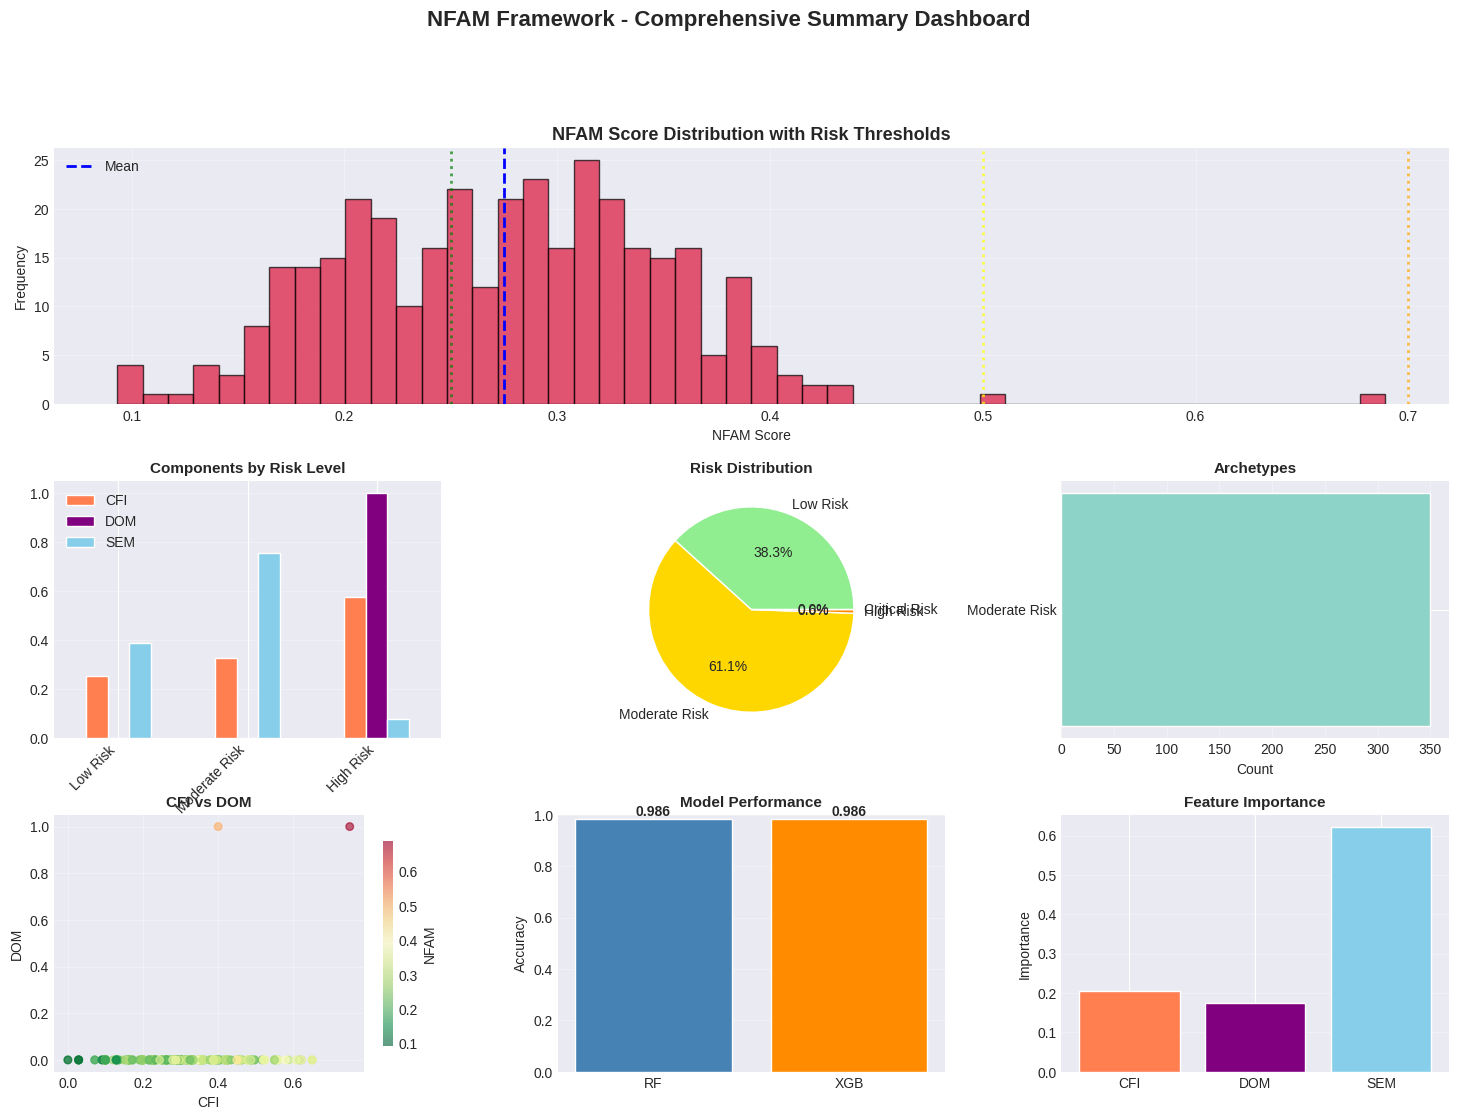

In [82]:
# ========================================
# 7. Comprehensive Summary Dashboard
# ========================================
print("[7/7] Generating comprehensive summary dashboard...")

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. NFAM distribution with thresholds
ax1 = fig.add_subplot(gs[0, :])
ax1.hist(df_norm['NFAM_Composite'], bins=50, alpha=0.7, color='crimson', edgecolor='black')
ax1.axvline(df_norm['NFAM_Composite'].mean(), color='blue', linestyle='--', linewidth=2, label='Mean')
for threshold, label, color in [(0.25, 'Low', 'green'), (0.50, 'Moderate', 'yellow'),
                                 (0.70, 'High', 'orange')]:
    ax1.axvline(threshold, color=color, linestyle=':', linewidth=2, alpha=0.7)
ax1.set_title('NFAM Score Distribution with Risk Thresholds', fontsize=13, fontweight='bold')
ax1.set_xlabel('NFAM Score')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Component scores by risk
ax2 = fig.add_subplot(gs[1, 0])
risk_order = ['Low Risk', 'Moderate Risk', 'High Risk', 'Critical Risk']
component_by_risk = df_norm.groupby('NFAM_Risk')[['CFI', 'DOM_normalized', 'SEM_inv_normalized']].mean()
component_by_risk = component_by_risk.reindex([r for r in risk_order if r in component_by_risk.index])
component_by_risk.plot(kind='bar', ax=ax2, color=['coral', 'purple', 'skyblue'])
ax2.set_title('Components by Risk Level', fontsize=11, fontweight='bold')
ax2.set_xlabel('Risk Level')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.legend(['CFI', 'DOM', 'SEM'])
ax2.grid(True, alpha=0.3, axis='y')

# 3. Risk distribution
ax3 = fig.add_subplot(gs[1, 1])
risk_counts = df_norm['NFAM_Risk'].value_counts()
ax3.pie([risk_counts.get(r, 0) for r in risk_order],
        labels=risk_order, autopct='%1.1f%%', colors=risk_colors)
ax3.set_title('Risk Distribution', fontsize=11, fontweight='bold')

# 4. Archetype distribution
ax4 = fig.add_subplot(gs[1, 2])
arch_counts = df_norm['Archetype_Name'].value_counts()
ax4.barh(arch_counts.index, arch_counts.values, color=plt.cm.Set3(range(len(arch_counts))))
ax4.set_title('Archetypes', fontsize=11, fontweight='bold')
ax4.set_xlabel('Count')
ax4.grid(True, alpha=0.3, axis='x')

# 5. CFI vs DOM scatter
ax5 = fig.add_subplot(gs[2, 0])
scatter = ax5.scatter(df_norm['CFI'], df_norm['DOM_normalized'],
                     c=df_norm['NFAM_Composite'], cmap='RdYlGn_r', s=30, alpha=0.6)
ax5.set_title('CFI vs DOM', fontsize=11, fontweight='bold')
ax5.set_xlabel('CFI')
ax5.set_ylabel('DOM')
plt.colorbar(scatter, ax=ax5, label='NFAM', shrink=0.8)
ax5.grid(True, alpha=0.3)

# 6. Model accuracy
ax6 = fig.add_subplot(gs[2, 1])
ax6.bar(['RF', 'XGB'], [acc_rf, acc_xgb], color=['steelblue', 'darkorange'])
ax6.set_title('Model Performance', fontsize=11, fontweight='bold')
ax6.set_ylabel('Accuracy')
ax6.set_ylim(0, 1)
ax6.grid(True, alpha=0.3, axis='y')
for i, (model, acc) in enumerate(zip(['RF', 'XGB'], [acc_rf, acc_xgb])):
    ax6.text(i, acc, f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# 7. Feature importance
ax7 = fig.add_subplot(gs[2, 2])
ax7.bar(['CFI', 'DOM', 'SEM'], xgb_model.feature_importances_,
        color=['coral', 'purple', 'skyblue'])
ax7.set_title('Feature Importance', fontsize=11, fontweight='bold')
ax7.set_ylabel('Importance')
ax7.grid(True, alpha=0.3, axis='y')

plt.suptitle('NFAM Framework - Comprehensive Summary Dashboard',
             fontsize=16, fontweight='bold', y=0.995)
plt.savefig('nfam_comprehensive_summary.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: nfam_comprehensive_summary.png")

print("\n" + "="*80)
print("✅ ALL VISUALIZATIONS GENERATED SUCCESSFULLY!")
print("="*80)
print(f"""
Generated Files:
  1. cfi_analysis.png
  2. dom_analysis.png
  3. sem_analysis.png
  4. nfam_composite_analysis.png
  5. behavioral_archetypes.png
  6. predictive_model_analysis.png
  7. nfam_comprehensive_summary.png

All visualization files saved in current directory!
""")


In [85]:
lime_exp.show_in_notebook(show_table=True)
